## 判斷是否使用Google colab執行
若是，則從Google Drive掛載資料，Google colab專用
否則應設定 ROOT_DIR

In [1]:
try:
    from google.colab import drive
    IN_COLAB = True
except:
    IN_COLAB = False

print('IN_COLAB', IN_COLAB)

if IN_COLAB:
    drive.mount('/content/drive', force_remount=True)
    ROOT_DIR = '/content/drive/Shared drives/Straight A students/類神經網路/BDRW'
else:
    ROOT_DIR = 'BDRW'

IN_COLAB True
Mounted at /content/drive


In [0]:
import torch

torch.manual_seed(1)
n_epoch = 20
batch_size = 100
learning_rate = 0.0002

## imports

In [0]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import skimage.io
import pdb
import torchvision
import cv2
import csv
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision import datasets

## 載入BDRW

In [0]:
class BDRWDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.labels = []
        self.labelsdic = {}
        with open(os.path.join(root_dir, 'labels.csv')) as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                # print(row)
                self.labels.append(row)
                self.labelsdic[row[0]] = int(row[1])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        if idx < 984:
            img_name = os.path.join(self.root_dir, 'BDRW_train_1', self.labels[idx][0]+'.jpg')
        else:
            img_name = os.path.join(self.root_dir, 'BDRW_train_2', self.labels[idx][0]+'.jpg')

        image = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise Exception('{} not found'.format(img_name))
        image = cv2.resize(image, (28, 28))
        _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        # _, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
        if np.sum(image>128) > 392:
            image = cv2.bitwise_not(image)
        image = image/255
        image = image.astype(np.float32)
        image = image.reshape(1, 28, 28)

        return image, self.labelsdic[self.labels[idx][0]]

In [0]:
bdrw_dataset = BDRWDataset(root_dir=ROOT_DIR)
train_loader = DataLoader(dataset = bdrw_dataset, batch_size = batch_size, shuffle = True)

## 主程式

In [0]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding = 1),
            nn.ReLU()
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(x.shape[0], -1)
        return out


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, 2, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 128, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 64, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 32, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 1, 3, 2, 1, 1),
            nn.ReLU()
        )

    def forward(self, x):
        out = x.view(x.shape[0], 256, 7, 7)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

In [7]:
encoder = Encoder().cuda()
decoder = Decoder().cuda()
parameters = list(encoder.parameters()) + list(decoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr = learning_rate)

# noise = torch.rand(batch_size, 1, 28, 28)
# cnt = 0
for I in range(n_epoch):
    for image, label in train_loader:
        # print(image.shape, label)
        temp_batch_size = image.shape[0]
        image_n = torch.mul(image + 0.25, 0.1 * torch.rand(temp_batch_size, 1, 28, 28))
        # cnt += 1
        # print(cnt, image_n.shape)
        image = Variable(image).cuda()
        image_n = Variable(image_n).cuda()
        optimizer.zero_grad()
        output = encoder(image_n)
        output = decoder(output)
        loss = loss_func(output, image)
        loss.backward()
        optimizer.step()

    print('epoch [{}/{}], loss:{:.4f}'.format(I + 1, n_epoch, loss.data.item()))

epoch [1/20], loss:0.2353
epoch [2/20], loss:0.1450
epoch [3/20], loss:0.0979
epoch [4/20], loss:0.0885
epoch [5/20], loss:0.0759
epoch [6/20], loss:0.0741
epoch [7/20], loss:0.0685
epoch [8/20], loss:0.0641
epoch [9/20], loss:0.0574
epoch [10/20], loss:0.0630
epoch [11/20], loss:0.0564
epoch [12/20], loss:0.0547
epoch [13/20], loss:0.0524
epoch [14/20], loss:0.0524
epoch [15/20], loss:0.0545
epoch [16/20], loss:0.0464
epoch [17/20], loss:0.0504
epoch [18/20], loss:0.0472
epoch [19/20], loss:0.0457
epoch [20/20], loss:0.0435


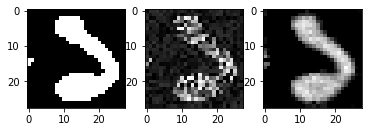

tensor(1)


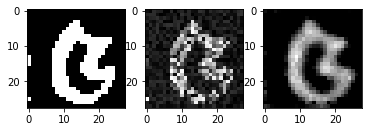

tensor(1)


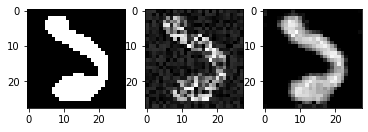

tensor(1)


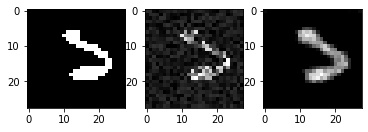

tensor(1)


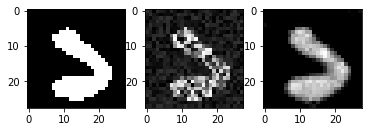

tensor(1)


In [8]:
for i in range(5):
    img = image[i].cpu()
    input_img = image_n[i].cpu()
    output_img = output[i].cpu()
    origin = (img.data).detach().numpy()
    inp = (input_img.data).detach().numpy()
    out = (output_img.data).detach().numpy()
    plt.figure('denoising autoencoder')
    plt.subplot(131)
    plt.imshow(origin[0], cmap = 'gray')
    plt.subplot(132)
    plt.imshow(inp[0], cmap = 'gray')
    plt.subplot(133)
    plt.imshow(out[0], cmap = 'gray')
    plt.show()
    print(label[0])